<a href="https://colab.research.google.com/github/philippe753/CNN_project/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import glob
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision 
from matplotlib import pyplot as plt
import gc
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, AveragePooling2D, Conv2D, MaxPooling2D
from keras.preprocessing import image
from keras.optimizers import SGD, Adam
from keras.callbacks import TensorBoard
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, plot_roc_curve
from sklearn.neural_network import MLPClassifier
import pickle
import time
import cv2

In [ ]:
# unzip the data frame containing the celebraties images
!unzip "/content/drive/MyDrive/AI_dataset/img_align_celeba.zip"

In [ ]:
  # Importing data
  data_Y = pd.read_excel("/content/drive/MyDrive/AI_dataset/list_attr_celeba.xlsx")
  data_Y_columns = data_Y.iloc[0] # This contains the name of the features/columns of the dataframe.

  # Inspecting Data

  # plot of the first 5 columns of the raw data
  print("Raw data frame: \n")
  print(data_Y.head(5))


  data_Y = data_Y.replace(-1, 0) # Replace -1 for a 0.
  # Deleating the first row, since it contains it just a interger refereing to the total number of imgs.
  first_row = data_Y.iloc[0] #grab the first row for the header
  data_Y = data_Y[1:] #take the data less the header row
  data_Y.columns = first_row #set the header row as the df header
  print('New data frame: \n')
  data_Y.head(5)

Raw data frame: 

       202599        Unnamed: 1  ...      Unnamed: 39 Unnamed: 40
0           #  5_o_Clock_Shadow  ...  Wearing_Necktie       Young
1  000001.jpg                -1  ...               -1           1
2  000002.jpg                -1  ...               -1           1
3  000003.jpg                -1  ...               -1           1
4  000004.jpg                -1  ...               -1           1

[5 rows x 41 columns]
New data frame: 



,#,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
1,000001.jpg,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,1,0,0,1
2,000002.jpg,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,000003.jpg,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
4,000004.jpg,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,1
5,000005.jpg,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1


In [ ]:
# download dataframe y

#pickle_out =  open("X.pickle", "bw")
#pickle.dump(training_data, pickle_out)
#pickle_out.close()

In [3]:
# Load data frame y
data_Y = pickle.load(open("/content/drive/MyDrive/AI_dataset/y.pickle","rb"))
#data_X = pickle.load(open("X.pickle","rb"))

## Description of our data Frame
As we can see bellow, most examples are not bold, do not have Clock shadow, do not have bangs, do not have blond hair, do not have double chin, do not have eyeglasses, do not have a Goatee, nor gray_hair, nor mustache, nor male skin, nor have a recending hairline, nor have rosy cheeks,nor side burns, nor wearing a hat, nor wearing a necktie.

The first model we'll learn is a  simple logisitc neural network to try to predict attrative and non attrative people. 

In [ ]:
data_Y.describe()

,#,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
count,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599,202599
unique,202599,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,093762.jpg,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
freq,1,180083,148509,103833,161153,198052,171890,153814,155083,154127,172616,192287,161027,173796,190936,193140,189406,189883,194100,124209,110410,118165,104657,194182,179270,169158,145032,193898,146389,186436,189284,191150,104930,160377,137855,164323,192781,106884,177686,187867,156734


## Randomly pick m images to be the training set.
Every image is flattened from a 3 dimmensional array to a 1-dimensional array and then standarized.

In [ ]:
# randomly sample all the attractive people
data_Y_attractive = data_Y[data_Y["Attractive"] == 1]["Attractive"].sample(frac=1)
data_Y_attractive_idx = data_Y_attractive.index[0:]

data_Y_unattractive = data_Y[data_Y["Attractive"] == 0]["Attractive"].sample(frac=1)
#data_Y_unattractive = np.random.shuffle(data_Y_unattractive)
data_Y_unattractive_idx = data_Y_unattractive.index[0:]


In [ ]:
data_Y_attractive_idx[0]

166201

In [ ]:
# randomly sample all the attractive people
m_train = 1500
#m_test = 100
num_features = 116412
train_Y_attractive = data_Y_attractive.head(m_train)
#test_Y_attractive = data_Y_attractive.head(m_test)
attractive_idx = data_Y_attractive_idx[0:(m_train)] #+m_test
train_X_attractive = np.zeros((num_features, m_train))
#test_X_attractive = np.zeros((num_features, m_test))

# the same for the unattractive data set
train_Y_unattractive = data_Y_unattractive.head(m_train)
#test_Y_unattractive = data_Y_attractive.head(m_test)
unattractive_idx = data_Y_unattractive_idx[0:(m_train)]#+m_test
train_X_unattractive = np.zeros((num_features, m_train))
#test_X_unattractive = np.zeros((num_features, m_test))

img_path = np.sort(glob.glob("img_align_celeba/*.*"))

# randomly select samples from the attractive data set, and flatter it to an array
for i in range(0, m_train):
    img = cv2.imread(img_path[attractive_idx[i]])
    img_v = img.reshape((img.shape[0] * img.shape[1] * img.shape[2], 1))
    #if i < m_train:
        # for training set:
    train_X_attractive[:, i] = img_v[:, 0]
    #elif i>=m_train: 
    #    # for test set:
    #    test_X_attractive[:, (i-m_train)] = img_v[:, 0]

# randomly select samples from the unattractive data set, and flatter it to an array
for i in range(0, m_train):
    img = cv2.imread(img_path[unattractive_idx[i]])
    img_v = img.reshape((img.shape[0] * img.shape[1] * img.shape[2], 1))
    #if i < m_train: 
    train_X_unattractive[:, i] = img_v[:, 0]
    #elif i>=m_train:
    #    # for test set:
    #    test_X_unattractive[:, (i-m_train)] = img_v[:, 0]


In [ ]:
X = np.concatenate((train_X_attractive, train_X_unattractive), axis=1)
X.shape
y = np.reshape(np.concatenate((train_Y_attractive, train_Y_unattractive)), (1, -1))
############ TO DO ##############3
# try to make the sets in cointain both the attractive and unattractive .

In [ ]:
y = y
X = X
print("X_train shape is: " + str(X.shape))
print("y is: " + str(y.shape))

X_train shape is: (116412, 3000)
y is: (1, 3000)


In [ ]:
X_train_f, X_test_f, y_train_f,  y_test_f = train_test_split(X,
                                                             y,
                                                             test_size=0.1,
                                                             random_state=42)

In [91]:
data_Y[data_Y['#'] == data_Y.iloc[(10)][0]]

,#,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
11,000011.jpg,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


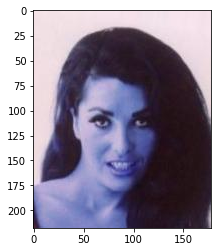

In [90]:
img = cv2.imread(img_path[10])
plt.imshow(img)

### Randomly picking data - part 2

In [4]:
m =  2000 # number of examples to train the models
m_test = 200
num_features = 29103 #116412 # num of features for each image
train_X = np.zeros((num_features, m))
train_Y = pd.DataFrame(data=data_Y.columns, columns=data_Y.columns)
test_X = np.zeros((num_features, m_test))
test_Y = pd.DataFrame(data=data_Y.columns, columns=data_Y.columns)
# random numbers to selecet the training examples from the data frame.
rand_num = np.random.choice(range(202599), (m + m_test), replace=False) 
img_path = np.sort(glob.glob("img_align_celeba/*.*"))

for i in range(0, m + m_test):
    img = cv2.imread(img_path[rand_num[i]])
    # flat image into an array.
    img =  cv2.resize(img, (109, 89))
    img_v = img.reshape((img.shape[0] * img.shape[1] * img.shape[2], 1))
    if i < m:
        train_X[:, i] = img_v[:, 0]
        # find the equivalent samples in data_Y.
        train_Y = pd.concat([train_Y, data_Y[data_Y['#'] == data_Y.iloc[(rand_num[i])][0]]]) #, ignore_index=True)

    elif i>=m:
        # same as above but for the test set.
        test_X[:, (i-m)] = img_v[:, 0]
        test_Y = pd.concat([test_Y, data_Y[data_Y['#'] == data_Y.iloc[rand_num[i]][0]]]) #, ignore_index=True)

# Standardize data
train_X = train_X / 255.0
test_X = test_X / 255.0

# For now, we are only interested on the attribute attractive.
train_Y_attractive = train_Y['Attractive']
train_idx = train_Y_attractive.index[0:]
#train_Y_attractive = train_Y_attractive.values.reshape((1, -1))
test_Y_attractive = test_Y['Attractive']
test_idx = test_Y_attractive.index[0:]
#test_Y_attractive = test_Y_attractive.values.reshape((1, -1))

In [95]:
## Visualizing the training set. 
# Note that since our models were randomly chosen from the data frame, then this
# sample should be a good representation of the Data Frame.
print("train_X shape is: " + str(train_X.shape))
print("train_Y_attractive shape is: " + str(train_Y_attractive.shape))
print("test_X shape is: " + str(test_X.shape))
print("test_Y_attractive shape is: " + str(test_Y_attractive.shape))


train_X shape is: (29103, 2000)
train_Y_attractive shape is: (2000,)
test_X shape is: (29103, 200)
test_Y_attractive shape is: (200,)


## Dueling with Imbalance data
Note that over 51 percent of the data samples in the data frame are attractive people. Therfore, the deep neural network will be more bias towards predicting the that a particulat example is attractive.

In [5]:
num_attractive = len(train_Y_attractive[train_Y_attractive==1])
num_unattractive = len(train_Y_attractive[train_Y_attractive==0])
print("Percentage of attractive people in the data frame: {0:.2f}%.".format(np.mean(data_Y["Attractive"])*100)) 
print("Percentage of attractive people in the training data: {0:.2f}%.".format(np.mean(train_Y_attractive)*100)) 
print("number of attractive people in training set: {}".format(num_attractive))
print("number of unaattractive people in training set: {}".format(num_unattractive))

Percentage of attractive people in the data frame: 51.25%.
Percentage of attractive people in the training data: 50.90%.
number of attractive people in training set: 1018
number of unaattractive people in training set: 982


To mitigate this problem, we'll implement weights to each class (in this case attractive and non attractive people)

In [ ]:
# class weights to balance the training between classes

#class_weights = []
#for i in range(1)): # we only need two weights
#    class_weights.append(len(num_attractive) / (2 * train_df[labels].sum()[i]))
#class_weights_dict = {i: class_weights[i] for i in range(0, len(class_weights))}

In [6]:
# deleate attrative deta set from the training data so we get the we do not get
# an imbalanced data set.
rand_num = rand_num.tolist()
num_attractive = len(train_Y_attractive[train_Y_attractive==1])
num_unattractive = len(train_Y_attractive[train_Y_attractive==0])
attractive_idx = train_Y_attractive[train_Y_attractive == 1].index
unattractive_idx = train_Y_attractive[train_Y_attractive == 0].index
del_idx = []
count=0

if num_attractive > num_unattractive:
    del_num = num_attractive - num_unattractive
    randn_num = np.random.choice(range(num_attractive-del_num), (del_num), replace=False) 
    while num_attractive > num_unattractive:
        del_idx.append(rand_num.index(attractive_idx[randn_num[count]]-1))
        del_attractive = train_Y_attractive[train_Y_attractive == 1].index[randn_num[count]]
        del train_Y_attractive[del_attractive]
        num_attractive = num_attractive - 1
        count +=1
    train_X_f = np.delete(train_X, del_idx, axis=1)

if num_attractive < num_unattractive:
    del_num = num_unattractive - num_attractive
    randn_num = np.random.choice(range(num_unattractive-del_num), (del_num), replace=False) 
    while num_attractive < num_unattractive:
        del_idx.append(rand_num.index(unattractive_idx[randn_num[count]]-1))
        del_unattractive = train_Y_attractive[train_Y_attractive == 0].index[randn_num[count]]
        del train_Y_attractive[del_unattractive]
        num_unattractive = num_unattractive - 1
        count += 1
    train_X_f = np.delete(train_X, del_idx, axis=1)


In [7]:
# New training set:
print("Percentage of attractive people in the training data: {0:.2f}%.".format(np.mean(train_Y_attractive)*100)) 
print("number of attractive people in training set: {}".format(num_attractive))
print("number of unaattractive people in training set: {}".format(num_unattractive))
print("train_X_f shape: {}".format(train_X_f.shape))
print("train_Y_attractive shape: {}".format(train_Y_attractive.shape))

Percentage of attractive people in the training data: 50.00%.
number of attractive people in training set: 982
number of unaattractive people in training set: 982
train_X_f shape: (29103, 1964)
train_Y_attractive shape: (1964,)


Now we have the same number of attractive and unattractive people in our training data.

In [110]:
print("Percentage of attractive people {0:.2f}%".format(np.mean(train_Y_attractive)*100))
print(train_Y_attractive.size) 

Percentage of attractive people 50.00%
1994


## Perceptron model to predict attractive and non-attractive people.

We will implement the most basic implementation of a neural network to see how good a single layer neural network can accurately predict if a person is attractive or not. 

In [8]:
train_X = train_X_f.T
train_Y_attractive = np.array(train_Y_attractive, dtype=np.float).T
test_X = test_X.T
test_Y_attractive = np.array(test_Y_attractive, dtype=np.float).T
test_idx = np.array(test_idx, dtype=np.int)

In [112]:
print(train_X.shape)
print(train_Y_attractive.shape)
print(test_X.shape)
print(test_Y_attractive.shape)


(1994, 29103)
(1994,)
(200, 29103)
(200,)


In [15]:
max_iter = 1000
eta0 = 0.01

ppn = Perceptron(penalty = 'elasticnet',
                 max_iter=max_iter, 
                 eta0=eta0, 
                 random_state = 0)

ppn.fit(train_X, train_Y_attractive)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=0.01,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty='elasticnet', random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [16]:
# Predict
y_pred_train = ppn.predict(train_X)
y_pred = ppn.predict(test_X)
y_pred = y_pred.astype(int)
# Accuracy of the test set
print("accuracy on the training set: {0:.2f}%",
      format(accuracy_score(train_Y_attractive,
                            y_pred_train)*100))

print("accuracy on the test set: {0:.2f}%",
      format(accuracy_score(test_Y_attractive,
                            y_pred)*100))

accuracy on the training set: {0:.2f}% 94.64285714285714
accuracy on the test set: {0:.2f}% 67.0


true positive prediction:


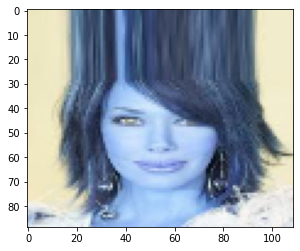

In [ ]:
# plot some images of the test set for which the perceptron was correct
count_correct_atract = 0
for pred in y_pred:
    if y_pred[pred] == int(test_Y_attractive[pred]) and (
        int(test_Y_attractive[pred]) == 1 and count_correct_atract == 0):
        print('true positive prediction:')
        img = cv2.imread(img_path[test_idx[pred]])
        img =  cv2.resize(img, (109, 89))
        count_correct_atract +=1
        plt.imshow(img)
    if count_correct_atract > 0:
      break
    plt.show()

true negative prediction:


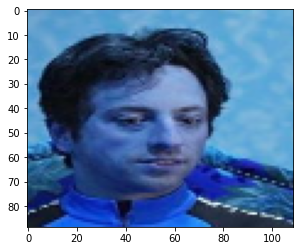

In [ ]:
count_correct_unatract = 0
for pred in range(y_pred.size):
    if y_pred[pred] == int(test_Y_attractive[pred]) and (
      int(test_Y_attractive[pred]) == 0 and count_correct_unatract == 0):
        print('true negative prediction:')
        img = cv2.imread(img_path[test_idx[pred]])
        img =  cv2.resize(img, (109, 89))
        count_correct_unatract +=1
        plt.imshow(img)
    if count_correct_unatract > 0:
        break
    plt.show()

Flase positive prediction:


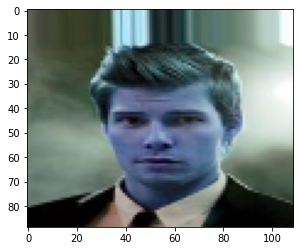

In [ ]:
count_incorrect_atract = 0
count = 0
for pred in range(y_pred.size):
    if y_pred[pred] != int(test_Y_attractive[pred]) and (
      int(test_Y_attractive[pred]) == 1 and count_incorrect_atract == 0):
        print('Flase positive prediction:')
        img = cv2.imread(img_path[test_idx[pred]])
        img =  cv2.resize(img, (109, 89))
        count_incorrect_atract +=1
        plt.imshow(img)
    if count_incorrect_atract > 0:
        break
    plt.show()
    

Flase negative prediction:


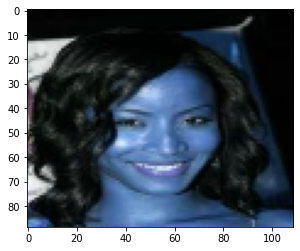

In [ ]:
count_incorrect_unatract = 0
for pred in range(y_pred.size):
    if y_pred[pred] != int(test_Y_attractive[pred]) and (
      int(test_Y_attractive[pred]) == 0 and count_incorrect_unatract == 0):
        print('Flase negative prediction:')
        img = cv2.imread(img_path[test_idx[pred]])
        img =  cv2.resize(img, (109, 89))
        count_incorrect_unatract +=1
        plt.imshow(img)
    if count_incorrect_unatract > 0:
        break
    plt.show()

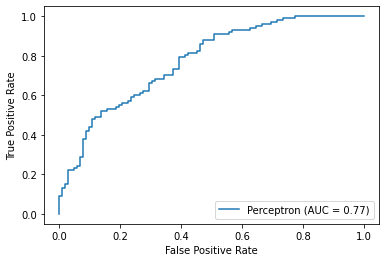

In [17]:
# ROC curve for the perceptron model
plot_roc_curve(ppn,  test_X, test_Y_attractive)

## Multilayer perceptron (MLP)

In [118]:
train_Y_attractive[0:100]

array([0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
       1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1.])

In [ ]:
first_layer = int(np.ceil(num_features/8))
#hidden_layer_sizes=(first_layer, 20, 7, 5, 1)
#solver='lbfgs'
nn = MLPClassifier(activation='logistic', max_iter=100, alpha = 0.000005, solver='lbfgs', hidden_layer_sizes=(first_layer, 10, 1), random_state = 0)

nn.fit(train_X, train_Y_attractive)

In [ ]:
# Predict
y_pred_train_nn = nn.predict(train_X)
y_pred_nn = nn.predict(test_X)
# Accuracy of the test set
print("accuracy on the training set: {0:.2f}%",
      format(accuracy_score(train_Y_attractive,
                            y_pred_train_nn)*100))

print("accuracy on the test set: {0:.2f}%",
      format(accuracy_score(test_Y_attractive,
                            y_pred_nn)*100))

In [ ]:
y_pred_nn

In [ ]:
# ROC curve for the perceptron model
plot_roc_curve(nn,  test_X, test_Y_attractive)

In [ ]:
# Implementing a deep neural network

class DeepNN:

    def __init__(self, learning_rate=0.01, num_ite=1000):
        self.learning_rate = learning_rate
        self.num_ite = num_ite

    def initialize_parameters_deep(self, layer_dims):
        parameters = {}
        L = len(layer_dims) # number of layers in the network
        for l in range(1, L):
            parameters["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
            parameters["b" + str(l)] = np.zeros((layer_dims[l], 1))
        return parameters

    def fit(self, X, Y, layers_dims):
        costs = []                        
        # Initialize parameters
        parameters = self.initialize_parameters_deep(layers_dims)
        for i in range(0, self.num_ite):
            print(i)
            # Forward propagation: with a relu and then sigmoid activation function
            AL, caches = self.L_model_forward(X, parameters)
            # Cost function
            cost  = self.compute_cost(AL, Y)
            # Initializing backward propagation
            grads = self.L_model_backward(AL, Y, caches)
            # Update the paramters.
            parameters = self.update_parameters(parameters, grads, self.learning_rate)

            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        return parameters, costs 

    def linear_forward(self, A, W, b):
        # Implement the linear part of a layer's forward propagation. ( CHANGE )
        Z = np.dot(W, A) + b
        cache = (A, W, b)  
        return Z, cache

    def L_model_forward(self, X, parameters):
        # Implement the linear part of a layer's forward propagation.
        caches = []
        A = X
        L = len(parameters) // 2 
        # loop every layer
        for l in range(1, L):
            A_prev = A 
            A, cache = self.linear_activation_forward(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], "relu")
            caches.append(cache)
        AL, cache = self.linear_activation_forward(A, parameters["W" + str(L)], parameters["b" + str(L)], "sigmoid")
        caches.append(cache)
        return AL, caches

    def linear_backward(self, dZ, cache):
        # Implement the linear portion of backward propagation for a single layer ( CHANGE )
        A_prev, W, b = cache
        m = A_prev.shape[1]
        dW = (1./m) * np.dot(dZ, A_prev.T)
        db = (1./m) * np.sum(dZ, axis = 1, keepdims=True)
        dA_prev = np.dot(W.T, dZ)        
        return dA_prev, dW, db

    def L_model_backward(self, AL, Y, caches):
        grads = {}
        L = len(caches) # the number of layers
        m = AL.shape[1]
        Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
        dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
        current_cache = caches[L-1]
        dA_prev_temp, dW_temp, db_temp = self.linear_activation_backward(dAL, current_cache, "sigmoid")
        grads["dA" + str(L)] = dA_prev_temp
        grads["dW" + str(L)] = dW_temp
        grads["db" + str(L)] = db_temp
        for l in reversed(range(L-1)):
            current_cache = caches[l]
            dA_prev_temp, dW_temp, db_temp = self.linear_activation_backward(grads["dA" + str(l + 2)], current_cache, "relu")
            grads["dA" + str(l + 1)] = dA_prev_temp
            grads["dW" + str(l + 1)] = dW_temp
            grads["db" + str(l + 1)] = db_temp
        return grads

    def linear_activation_forward(self, A_prev, W, b, activation):
        # Implement the forward propagation for the LINEAR->ACTIVATION layer
        Z, linear_cache = self.linear_forward(A_prev, W, b)
        Z = np.array(Z,dtype=np.float32)
        if activation == "sigmoid":
            A = 1/(1 + np.exp(-Z))
        elif activation == "relu":
            A = np.maximum(Z, 0)
        cache = (linear_cache, Z)  
        return A, cache

    def linear_activation_backward(self, dA, cache, activation):
        # Backward propagation.
        linear_cache, activation_cache = cache
        Z = activation_cache
        if activation == "relu":
          # Implement Back propagation witha relu activation function
            dsig = np.where(Z>0, 1, 0)
            dZ = dA * dsig
            dA_prev, dW, db = self.linear_backward(dZ, linear_cache)
        elif activation == "sigmoid":
          # Implement Back propagation witha sigmoid activation function
            dsig = 1/(1+np.exp(-Z)) * (1 - 1/(1+np.exp(-Z)))
            dZ = dA * dsig    #= self.sigmoid_backward(dA, activation_cache)
            dA_prev, dW, db = self.linear_backward(dZ, linear_cache)
        return dA_prev, dW, db

    def compute_cost(self, AL, Y):
        cost = -(1/m) * (np.dot(Y, np.log(AL).T) + np.dot((1 - Y), np.log(1-AL).T))
        cost = np.squeeze(cost)
        return cost

    def update_parameters(self, params, grads, learning_rate):
        # Update the weiths and bieses of each layer
        parameters = params.copy()
        L = len(parameters) // 2
        for l in range(L):
            parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
            parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        return parameters

    def prediction(self, test_X, test_Y, parameters):
        AL, caches = self.L_model_forward(test_X, parameters)
        y_hat = np.where(AL>=0.5, 1, 0)
        m = y_hat.shape[1]
        y_percentage = ( 1 - (1/m) * np.sum(abs(y_hat - test_Y)) ) * 100
        # The unit step activation function returns only 1 or 0.
        return y_hat, y_percentage

      

In [ ]:
layers_dims = [29103, 20, 7, 5, 1]
              
my_deepNN = DeepNN(learning_rate=0.0075, num_ite=2500)
parameters, costs = my_deepNN.fit(train_X, train_Y_attractive, layers_dims)
#parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

NameError: ignored

In [ ]:
y_hat, y_percentage = my_deepNN.prediction(test_X, test_Y_attractive, parameters)

In [ ]:
print(y_hat)
print(y_percentage)


In [ ]:
print(test_Y_attractive)
print(y_hat - test_Y_attractive)


In [ ]:
# Convolutional neural network
resnet = ResNet50(include_top=False, pooling='avg')
model = Sequential()
model.add(resnet)
model.add(Dense(1))
model.layers[0].trainable = False

_ = model(tf.zeros([1, 218,178, 3]))

model.summary()

## Logistic Regression

## Convolutional Nueral Networks

In [ ]:
y = data_Y['Attractive'].head(5000)
y.describe()

count     5000
unique       2
top          1
freq      2561
Name: Attractive, dtype: int64

In [ ]:
X = torch.FloatTensor(training_data) #pickle.load(open("X.pickle", "rb"))
y = data_Y['Attractive'].head(5000)

X = X/255.0

In [ ]:
print([X.shape[1:]])

## Convolutional Neural Network using Keras

In [ ]:
## ---NEW SECTION---
# picking 75 and 75 attractive and unattractive people.
answers = data_Y['Attractive']
answers =answers.iloc[0:1050]
answers.mean()


0.5228571428571429

In [ ]:
from PIL import Image

imgs = []
#valid_images = [".jpg",".gif",".png",".tga"]

img_path = np.sort(glob.glob("img_align_celeba/*.*"))

for i in range(100):
    #img = cv2.imread(img_path[i])
    image = cv2.imread(img_path[i])
    img = np.array(image)
            
    imgs.append(img)

In [ ]:
images_tensor = torch.FloatTensor(imgs)
img_transpose = torch.transpose(images_tensor, 1, 3) #torch.reshape(images_tensor, (1050, 3, 218, 178))
img_transpose = img_transpose.transpose(2, 3)
img_transpose.size()

torch.Size([10, 3, 218, 178])

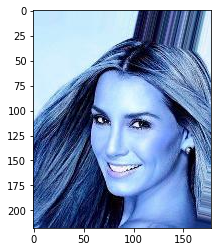

In [ ]:
# plot an image to make sure that everything is in order. Note that pythong plots images in gbr not in rbg.
tensor_img = img_transpose[10]/255
plt.imshow(tensor_img.permute(1, 2, 0))

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
#         self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(41820, 418)
        self.fc2 = nn.Linear(418, 44)
        self.fc3 = nn.Linear(44, 5)
        self.fc4 = nn.Linear(5, 2)

    def forward(self, x):
        x=x
        # (1) Input later "x = x"
        # (2) Hidden conv1 layer
#         x = self.conv1(x)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2)
#         x = F.relu(F.max_pool2d(self.conv1(x), 2))

        # (3) Hidden conv2 layer
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
#         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))

        # (4) Hidden linear layer
        x = x.view(x.size(0),  41820)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x

In [ ]:
model = Net()
model

Net(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=41820, out_features=418, bias=True)
  (fc2): Linear(in_features=418, out_features=44, bias=True)
  (fc3): Linear(in_features=44, out_features=5, bias=True)
  (fc4): Linear(in_features=5, out_features=2, bias=True)
)

In [ ]:
answers.astype('float64').values

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
       1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1.,
       1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0.,
       1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1.])

In [ ]:
answers_train = torch.from_numpy(answers.astype('float64').values)
answers_train2 = answers_train.long()

img_transpose_train = img_transpose
img_transpose_train.size()

torch.Size([1050, 3, 218, 178])

In [ ]:
cross_entropy_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00000000000001)

In [ ]:
for step in range(20):
    models = model(img_transpose_train)
    cross_entropy = cross_entropy_loss(models, answers_train2)
    total_cost = cross_entropy 
    
    print(total_cost)

    optimizer.zero_grad()
    total_cost.backward()
    optimizer.step()

In [ ]:
_ , predicted = torch.max(models.data, 1)
predicted

In [ ]:
_ , predicted = torch.max(models.data, 1)

final = answers_train2.size(0)
correct = (predicted == answers_train2).sum()
print('- Accuracy: %f %%' % (100 * float(correct) / final))
print('- CE : %2.2f,' % (cross_entropy.item()))

# keras Model

In [ ]:
#images_tensor = np.array(imgs)
X = np.array(imgs).astype('float64')/255
y = np.array(answers_train2) #np.array(data_Y["Attractive"].head(1050))
print(y)

[1 0 0 ... 1 1 1]


In [ ]:
# THIS WILL BE USE LATER TO ANALIZE THE CNN
# Tensorboard:
logdir = "/content/"
NAME = "Attractive-{}".format(int(time.time()))
tensorboard_callback = TensorBoard(log_dir=logdir+'logs/{}'.format(NAME))
#tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
model = Sequential()

model.add(Conv2D(64, (3,3), input_shape = X.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))  #, strides=None, padding='valid', data_format='channels_first'))

model.add(Conv2D(64, (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64))
model.add(Activation("relu"))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss="binary_crossentropy",
             optimizer="adam", 
             metrics=['accuracy'])

model.fit(X, y, batch_size=32,epochs=10, validation_split=0.1, callbacks =[tensorboard_callback])

In [ ]:
dense_layers = [0, 1, 2]
layer_sizes = [32, 64, 128]
conv_layers = [1, 2, 3]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size,  dense_layer, int(time.time()))
            tensorboard_callback = TensorBoard(log_dir=logdir+'logs/{}'.format(NAME))
            print(NAME)
            model = Sequential()

            model.add(Conv2D(64, (3,3), input_shape = X.shape[1:]))
            model.add(Activation("relu"))
            model.add(MaxPooling2D(pool_size=(2, 2)))  #, strides=None, padding='valid', data_format='channels_first'))

            for l in range(conv_layer-1):
                model.add(Conv2D(conv_layer, (3,3)))
                model.add(Activation("relu"))
                model.add(MaxPooling2D(pool_size=(2, 2)))

            model.add(Flatten())
            for l in range(dense_layer):
                model.add(Dense(dense_layer))
                model.add(Activation("relu"))
 
            model.add(Dense(1))
            model.add(Activation('sigmoid'))

            model.compile(loss="binary_crossentropy",
                        optimizer="adam", 
                        metrics=['accuracy'])

            model.fit(X, y, batch_size=32,epochs=10, validation_split=0.1, callbacks =[tensorboard_callback])

In [ ]:
# Load tensorboard:
%tensorboard --logdir /content/